# TIme depeNdent ConduiT flow neUral netwoRk Emulator (TINCTURE)

A collaboration between Ying Qi Wong, PhD and Ben Mullet

In [1]:
import hashlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import pickle
import tqdm
import json
import uuid

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import matlab.engine

import domegoveqn
import constitutive
import utils

In [2]:
%load_ext autoreload
%autoreload 2

## Gather training data

(This section is adapted from YQ's notebook "RunModel")

In [3]:
eng = matlab.engine.start_matlab()

path_to_domeconduit_code = "/home/bmullet/Research/software/domeconduit/Code/"  # on Ben's machine
path_to_domeconduit_code = "../domeconduit/Code/"  # on YQ's machine

eng.addpath (eng.genpath(path_to_domeconduit_code), nargout= 0 )

### Run time-dependent conduit model by calling matlab functions 

First start matlab and add paths for model functions


#### Run the full time-dependent model using default parameters

In [4]:
def n_by_1(array):
  """Transform array to Nx1"""
  array = np.array(array)
  
  assert len(array.shape) <= 2, "Array dim should be <= 2"
  
  if len(array.shape) < 2:
    array = array[:,np.newaxis]
  
  L, W = array.shape
  if L < W:
    array = array.T
    
  return array



In [5]:
#TODO: Collect relevant pieces into a class that keeps list of inputs/outputs neat and clean

# Global constants
CONDUIT_VAR_NAMES = ["p", "v", "phi_g", "mh"] # TODO: change to mh
#ACTIVATIONS = [tf.keras.backend.abs, tf.keras.backend.abs, tf.nn.sigmoid, tf.nn.sigmoid] # should match the order of CONDUIT_VAR_NAMES
ACTIVATIONS = [tf.nn.sigmoid, tf.nn.sigmoid, tf.nn.sigmoid, tf.nn.sigmoid] # should match the order of CONDUIT_VAR_NAMES

DEFAULT_PARAMS = eng.tdcFV('setdef', nargout=1)
DEFAULT_PARAMS['phi_gc'] = 0
MODEL_PARAM_VARIABLES = DEFAULT_PARAMS.keys()
DATA_CACHE_DIR = "./data_cache"

# Make sure the cache directory exists
pathlib.Path(DATA_CACHE_DIR).mkdir(parents=False, exist_ok=True)

def check_model_params(params):
  """
  Makes sure an object is a valid params dict
  """
  assert DEFAULT_PARAMS.keys() == params.keys(), "model params dict is not valid"

class matlab_conduit_data_loader():
  
  # Default parameter
  Nz = 401
    
  def __init__(self,
               model_params=DEFAULT_PARAMS,
               use_cache=True
               ):
    
    check_model_params(model_params)
    
    self.model_params = model_params
    
    # Make a file name from hasing the input dictionary
    hash_code = hashlib.sha1(json.dumps(self.model_params, sort_keys=True).encode()).hexdigest()
    self.file_name = os.path.join(DATA_CACHE_DIR, hash_code)
    
    # Load data
    loaded_data = False
    if pathlib.Path(self.file_name).is_file() and use_cache:
      # We've already computed this and cached the values, so load the cached data
      try:
        with open(self.file_name, "rb") as f:
          saved_data = pickle.load(f)
          self.ss     = saved_data['ss']
          self.opts   = saved_data['opts']
          self.ssflag = saved_data['ss_flag']
        loaded_data = True
      except Exception as e:
        print("Caught Exception:", e)
        print("Cannot load data. Will generate it from scratch.")
        
    if not loaded_data:
      
      # Compute data
      
      # adjust some parameters
      opts = eng.tdcFV('ss_init',model_params, nargout=1)
      #opts['plug_gas_loss'] = 0

      ss, opts, ssflag = eng.tdcFV('run_ssc_opts', opts, nargout=3) 
      #ss, opts, ssflag = eng.tdcFV('run_ssc', model_params, nargout=3)
      self.ss     = ss
      self.opts   = constitutive.reformat_params(ss['m'])
      self.ssflag = ssflag
      
      # Cache data
      if use_cache:
        with open(self.file_name, "wb") as f:
          data_to_save = {"ss" : self.ss, "opts" : self.opts, 
                          "ss_flag": self.ssflag}
          pickle.dump(data_to_save, f)
  
  def get_transformed_data(self):
    return conduit_data_transformer(self)
          

class conduit_data_transformer():
  # Transform matlab conduit data into python and TF objects
  
 
  def __init__(self, ml_conduit_data):
    
    # Extract the variables and gradients
    self.vars, self.grads = utils.get_steady_state_vars_and_grads(ml_conduit_data.ss)
    
    self.opts = ml_conduit_data.opts
  
  def create_tf_dataset(self):
    
    # create a dict to store the data
    tf_dict = {}
    
    # adds z, p, phi_g, v, m_w
    tf_dict.update({key : np.squeeze(var).astype(np.float32) for key, var in self.vars.items()})
    
    # adds gradients as nested dictionaries
    tf_dict["gradients"] = {key : np.squeeze(grad).astype(np.float32) for key, grad in self.grads.items()}
    
    # adds model parameters.
    uid = str(uuid.uuid4())
    tf_dict["uuid"] = uid
    opts = { uid : self.opts }
    
    # Get boundary conditions
    bottom_idx = np.argmin(tf_dict["z"])
    top_idx = np.argmax(tf_dict["z"])
    
    # Conduit bottom boundary conditions are set on p, phi_g, and m_h (not v)
    bottom_bcs = ["p", "phi_g", "mh"]
    
    # Conduit top boundary conditions are only set on p
    top_bcs = ["p"]

    # Creates a mask for those entries which are also boundary conditions
    conduit_bcs = {}
    for var in CONDUIT_VAR_NAMES:
      conduit_bcs[var] = np.zeros_like(tf_dict["z"]).astype(np.float32)
      if var in bottom_bcs:
        conduit_bcs[var][bottom_idx] = 1.0
      if var in top_bcs:
        conduit_bcs[var][top_idx] = 1.0
    
    tf_dict.update({"boundary_conditions" : conduit_bcs})
    
    # Create tf dataset
    dataset = tf.data.Dataset.from_tensors(tf_dict)
    
    return dataset, opts
  
def data_assembler_template(opts, input_vars=["z"], input_model_params=[], output_vars=CONDUIT_VAR_NAMES):
  """
  Creates a convenience function for splitting the dataset
  Inputs:
    opts: dictionary of opts from different models
    input_vars: list of primary vars (z, phi_g, mh, p, v) to include in input to model
    input_model_params: list of model params to include in input to model
    output_vars: list of primary vars (z, phi_g, mh, p, v) to predict with model
    
  Output:
    data_assembler function
  """
  
  assert input_vars[0] == "z", "First input variable needs to be z"
  
  def data_assembler(dataset):
    """Convenience function for splitting up a tf.dataset
    Inputs:
      dataset: tf.dataset of the form created by conduit_data_transformer
    Outputs:
      model_input: tensor that matches input_vars
      model_output: tensor that matches output_vars
      model_output_gradients: d()/dz gradients for output_vars
      model_params: dict of model_params tensors
      boundary_conditions: boundary conditions tensor mask
    """
    
    assert len(batch["uuid"]) == 1, "Data assembler is only set up for batch size of 1"
    
    uid = batch["uuid"].numpy()[0].decode('utf-8')
    
    # Load the opts associated with this batch
    batch_opts = opts[uid]
    
    # Create the input tensor
    model_input = tf.stack([tf.squeeze(dataset[var]) for var in input_vars], axis=1)
    
    # Add model parameters if we want to use those to train the model
    if len(input_model_params) > 0:
      dummy_tensor = tf.ones([model_input.shape[0]], dtype=tf.float32)
      model_input_model_params = tf.stack([dummy_tensor*batch_opts[var] for var in input_model_params], axis=1)
      
      model_input = tf.concat([model_input, model_input_model_params], axis=1)
    
    # Create the output tensor
    model_output = tf.stack([tf.squeeze(dataset[var]) for var in output_vars], axis=1)

    # Gradients. Again we need to squeeze and reshape to make sure we have Nx1 vectors
    model_output_gradients = {key : tf.squeeze(grad)[:,None] for key, grad in dataset["gradients"].items()}
    
    # Boundary conditions
    boundary_conditions = tf.stack([tf.squeeze(dataset["boundary_conditions"][var]) for var in output_vars], axis=1)
    
    return model_input, model_output, model_output_gradients, boundary_conditions, batch_opts
  
  return data_assembler

def plot_batch(model_input, model_output_true, model_output_pred=None, label=""):
    """Plot some output, given in_array and out_array"""
    
    # Cast to numpy
    if isinstance(model_input, tf.Tensor):
      model_input = model_input.numpy()
    if isinstance(model_output_true, tf.Tensor):
      model_output_true = model_output_true.numpy()
    if isinstance(model_output_pred, tf.Tensor):
      model_output_pred = model_output_pred.numpy()
      
    z = model_input[:,0]
    
    plt.figure(figsize=(15, 3))
    nsub = len(CONDUIT_VAR_NAMES)
    
    for i, var_name in enumerate(CONDUIT_VAR_NAMES):
      arrayi = model_output_true[:,i]
    
      plt.subplot(1, nsub, i+1)
      lines = plt.plot(arrayi, z)

      if model_output_pred is not None:
        arrayi2 = model_output_pred[:,i]
        plt.plot(arrayi2, z, "--r")
        
      plt.xlabel(label + var_name)
      plt.ylabel("z")
      
    plt.tight_layout()
    plt.show()
    
class data_transformer():

  def __init__(self, variable_bounds):
    """
    Create functions to normalize (and undimensionalize) and unnormalize our data
    Input:
      variable_bounds: dict of maxes and mins for normalizing
    Output:
      to_nondim: function for nondimensionalizing data
      to_dim: function for dimensionalizing data
    """

    mins  = tf.constant([variable_bounds[var]["min"] for var in CONDUIT_VAR_NAMES], dtype=tf.float32)
    maxes = tf.constant([variable_bounds[var]["max"] for var in CONDUIT_VAR_NAMES], dtype=tf.float32)

    def to_nondim(dimensional_tensor):
      return (dimensional_tensor - mins)/(maxes - mins)

    def to_dim(nondimensional_tensor):
      return (nondimensional_tensor*(maxes-mins) + mins)
    
    def to_nondim_z(x):
      # Assumes that z is the first column of x
      dimensional_z = x[:,0][:, None]
      nondimensional_z = (dimensional_z - variable_bounds["z"]["min"])/(variable_bounds["z"]["max"] - variable_bounds["z"]["min"])
      return tf.concat([nondimensional_z, x[:,1:]], axis=1)
    
    def to_dim_z(x):
      # Assumes that z is the first column of x
      nondimensional_z = x[:,0][:, None]
      dimensional_z = (nondimensional_z*(variable_bounds["z"]["max"] - variable_bounds["z"]["min"]) + variable_bounds["z"]["min"])
      return tf.concat([dimensional_z, x[:,1:]], axis=1)
      
    def unnormalize_z_gradient(nondimensional_gradient):
      # Unnormalizes the z part of the gradient
      if isinstance(nondimensional_gradient, list):
        return [unnormalize_z_gradient(grad) for grad in nondimensional_gradient]
      else:      
        return nondimensional_gradient/(variable_bounds["z"]["max"] - variable_bounds["z"]["min"])
      
    
    self.to_nondim = to_nondim
    self.to_dim = to_dim
    self.to_nondim_z = to_nondim_z
    self.to_dim_z = to_dim_z
    self.unnormalize_z_gradient = unnormalize_z_gradient
    

In [6]:
f = tf.constant([[-4000,1,2,3],[0,4,5,6]], dtype = tf.float32)
print(tf.concat([f[:,0][:,None], f[:,1:]], axis=1))
dt = data_transformer(mins_and_maxes)
print(dt.to_nondim_z(f))
#mins_and_maxes["z"]

tf.Tensor(
[[-4.e+03  1.e+00  2.e+00  3.e+00]
 [ 0.e+00  4.e+00  5.e+00  6.e+00]], shape=(2, 4), dtype=float32)


NameError: name 'mins_and_maxes' is not defined

In [7]:
print(CONDUIT_VAR_NAMES)

c = matlab_conduit_data_loader(use_cache=False)
d = c.get_transformed_data()

['p', 'v', 'phi_g', 'mh']


In [8]:
print(c.opts.keys())
c.opts['vvfrac_thr']=0.

dict_keys(['fr', 'p_top', 'ch', 'R', 'g', 'conduit_length', 'Ti', 'T', 'rho_l', 'rho_hd', 'rho_cd', 'rho_s', 'rho_c', 'Rw', 'Rc', 'B', 'sig', 'plug_gas_loss', 'k_lat', 'eta_g', 'phydro', 'phi_gc', 'klw', 'model', 'p_ch', 'mw_ch', 'phi_g_ch', 'Nz', 'pf', 'chi_ch', 'kc', 'vvfrac_thr', 'vi'])


In [9]:
mins_and_maxes = {}
for var in CONDUIT_VAR_NAMES + ["z"]:
  mins_and_maxes[var] = {
    "min" : np.min(d.vars[var]),
    "max" : np.max(d.vars[var])}
  
normalizer = data_transformer(mins_and_maxes)

In [10]:
dataset, opts = d.create_tf_dataset()

# Shows what one element of the dataset looks like
print(dataset.element_spec.keys())
print(dataset.element_spec["uuid"])
print(opts.keys())
print(list(opts.values())[0].keys())


dict_keys(['p', 'v', 'phi_g', 'mh', 'z', 'gradients', 'uuid', 'boundary_conditions'])
TensorSpec(shape=(), dtype=tf.string, name=None)
dict_keys(['ed53c1b2-96f9-4a19-a044-12f8587c1492'])
dict_keys(['fr', 'p_top', 'ch', 'R', 'g', 'conduit_length', 'Ti', 'T', 'rho_l', 'rho_hd', 'rho_cd', 'rho_s', 'rho_c', 'Rw', 'Rc', 'B', 'sig', 'plug_gas_loss', 'k_lat', 'eta_g', 'phydro', 'phi_gc', 'klw', 'model', 'p_ch', 'mw_ch', 'phi_g_ch', 'Nz', 'pf', 'chi_ch', 'kc', 'vvfrac_thr', 'vi'])


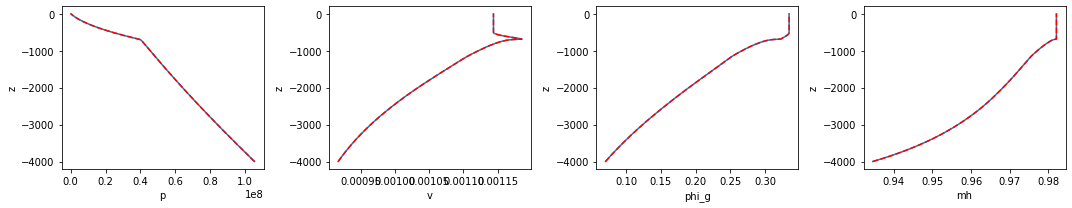

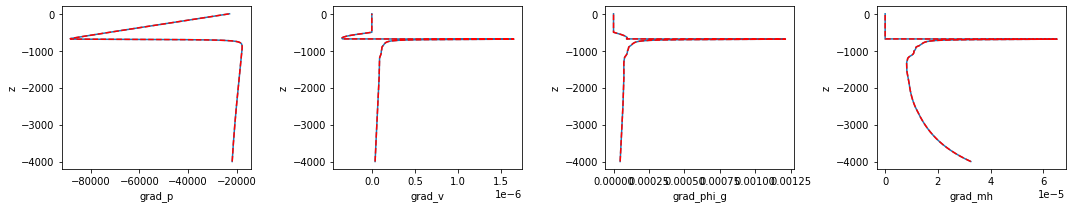

In [11]:
assembler = data_assembler_template(opts=opts, input_vars=["z"], input_model_params=[], output_vars=CONDUIT_VAR_NAMES)
batcher = dataset.batch(1)


for batch in batcher:
  model_input, model_output, model_output_gradients, boundary_conditions, batch_opts = assembler(batch)
  plot_batch(model_input, model_output, model_output)
  grads = np.concatenate([model_output_gradients[i] for i in model_output_gradients.keys()], axis=1)
  plot_batch(model_input,grads,grads, label="grad_")

  break


In [12]:
print(model_input[0:2])
print(model_input[1]-model_input[0])
print(model_output.shape)
print([f"{name} : {grad.shape}" for name, grad in model_output_gradients.items()])
print(boundary_conditions.shape)
print(model_output_gradients.keys())
print(np.concatenate([model_output_gradients[i] for i in model_output_gradients.keys()], axis=1))
#print(model_input)
print(batch_opts['fr']['A'])

tf.Tensor(
[[-4000.    ]
 [-3993.3333]], shape=(2, 1), dtype=float32)
tf.Tensor([6.666748], shape=(1,), dtype=float32)
(601, 4)
['p : (601, 1)', 'v : (601, 1)', 'phi_g : (601, 1)', 'mh : (601, 1)']
(601, 4)
dict_keys(['p', 'v', 'phi_g', 'mh'])
[[-2.1777895e+04  3.7924895e-08  4.6732886e-05  3.2517317e-05]
 [-2.1771875e+04  3.8046732e-08  4.6823377e-05  3.2313947e-05]
 [-2.1765828e+04  3.8168864e-08  4.6913992e-05  3.2112021e-05]
 ...
 [-2.4179660e+04  5.6890511e-17 -1.1857537e-14 -1.1368684e-16]
 [-2.3523125e+04  1.5909254e-17 -5.7576057e-15 -1.1101536e-16]
 [-2.2866621e+04 -3.6337014e-18  1.7014556e-15  7.4477924e-16]]
9.079985952496972e-10


### Set up model

In [13]:
# Neural network model

class PDENeuralNet(tf.keras.Model):
  def __init__(self, n_inputs, n_outputs, activations=None):
    assert (isinstance(activations, list)) or (activations is None), "Please provide a list of activations, if desired"
    
    if activations is not None:
      assert len(activations) == n_outputs, "Please provide an activation layer for each output"
    
    super().__init__()
    
    self.n_inputs = n_inputs
    self.n_outputs = n_outputs
    
    # Define model
    inputs = keras.Input(shape=(self.n_inputs,))
    x = Dense(100, activation=tf.nn.elu)(inputs)
    x = Dense(100, activation=tf.nn.elu)(x)
    x = Dense(40, activation=tf.nn.elu)(x)
    x = Dense(30, activation=tf.nn.elu)(x)
    x = Dense(10, activation=tf.nn.elu)(x)
    x = Dense(self.n_outputs, activation=None)(x)
    
    output = []
    if activations is not None:
      for xi, activation in zip(tf.unstack(x,axis=-1), activations):
        output.append(activation(xi))
      x = tf.stack(output, axis=1)
    
    self.nn_model = keras.Model(inputs=inputs, outputs=x, name="PDEModel")
        
    self(tf.zeros([1, self.n_inputs]))  # dummy call to build the model

  @tf.function
  def call(self, x):
    z = self.nn_model(x)
    return z

In [14]:
# Neural network parameters
N_INPUTS = 1
N_OUTPUTS = 4


In [15]:
testmodel = PDENeuralNet(N_INPUTS, N_OUTPUTS, activations=ACTIVATIONS)



In [19]:
OUTPUT_SCALING = tf.constant([1e7, 1e-3, 1/3, 0.95], dtype=tf.float32) # A dumb normalization for scaling the loss

def get_optimzer(type="Adam", lr=2e-2):
  """Sets up NN model optimizer"""
  if type=="Adam":
    trainer = tf.keras.optimizers.Adam(learning_rate = lr)
  else:
    trainer = tf.keras.optimizers.SGD(learning_rate = lr)
  return trainer

trainer = get_optimzer()

def get_conduit_vals(p, u, A):
  
  raise NotImplementedError

  return 


def get_physics(x, y, dydx, batch_opts):
  """Get the the governing equations.
  Inputs:
    x: (N x K) tensor of (z, [input_variables]) 
    y: (N x 4) tensor of (p,v,phi_g,m_g) primary conduit variables
    dydx: 4 element list of gradients
    batch_opts: dictionary of model parameters
  Returns:
    F: (N x M) tensor for the M governing equations for each of the N samples.
       Each entry should equal zero if the physics are satisfied.
  
  See the note at the bottom of this notebook for an explanation.
  """
      
  z = x[:,0][:,None] # Enforce Nx1
  
  conduit_values = [val for val in split_tensor(y)]
  conduit_variables = {var : conduit_values[i] for i, var in enumerate(CONDUIT_VAR_NAMES)}
  conduit_gradients = {var : {"z" : dydx[i][:,0][:,None]} 
                       for i, var in enumerate(CONDUIT_VAR_NAMES)}
  
  # Variables are accessible in the conduit_variables dictionary by key equal to their variable name
  #    e.g. conduit_variables["p"] is (Nx1) tensor for pressure
  # Gradients are accessible in the "conduit_gradients" two-level dictionary. First key is variable name;
  # second is the variable with respect to which to take the derivative.
  #    e.g. conduit_gradients["p"]["t"] is (Nx1) tensor for dpdt
  # Feel free to rename these variables/use as desired!

  ####### YING QI'S CODE HERE #############
  F = domegoveqn.ssc(z, conduit_variables, conduit_gradients, batch_opts)
  
  
  #########################################
  #raise NotImplementedError
  
  return F

def split_tensor(tensor):
  """Splits NxM tensor into M Nx1 dimensional tensors"""
  vectors = tf.unstack(tensor,axis=1)
  for v in vectors:
    yield v[:,None]
  
  
def conduit_loss(x, y, dydx, y_true, model_output_gradients, bc_mask, batch_opts, iteration):
  """Calculate the loss function"""
  loss_multipliers = tf.constant([1, 1e-5, 1, 1], dtype=tf.float32)
    
  # Start training by just trying to match the matlab output
  if iteration < N_DATA_EPOCHS:    
    F = np.zeros((1,4))
    loss = tf.reduce_mean(tf.square((normalizer.to_nondim(y) - normalizer.to_nondim(y_true))))
    
  # After a certain number of steps, switch to a "physics-informed" loss
  else:
    # We can multiply each of the equations by a constant to make sure they are
    # weighted equally (i.e. do a simple normalization)
    loss_multipliers = tf.constant([1, 1e-5, 1, 1], dtype=tf.float32)
    
    # F should be (Nx4), for the 4 governing equations
    F = get_physics(x, y, dydx, batch_opts)
    #import pdb; pdb.set_trace()
    
    # loss_multipliers will broadcast to multiply F
    physics_loss = tf.reduce_mean(tf.square(F*loss_multipliers)* (1-bc_mask))
    
    # Boundary condition loss. We use a binary mask to mask out all contributions
    # except for the values that represent the boundary conditions. (Note this
    # assumes that the matlab solution [in y_truey] satisfied the BCs.)
    bc_loss = tf.reduce_mean(tf.square((y - y_true)/y_true) * bc_mask)
    
    loss = physics_loss  + bc_loss
 
  return loss, F*loss_multipliers
      
def train(model, dataset):
  trainer = get_optimzer()
  
  assembler = data_assembler_template(opts, input_vars=["z"], input_model_params=[], output_vars=CONDUIT_VAR_NAMES)
  
  loss_best = 1e6 # arbitrary high number
  
  lr_counter = 0
  
  plot_every = 1000

  # Iterate over epochs
  for i in tqdm.trange(N_EPOCHS, desc="Training"):
    
    batches = dataset.batch(601)
    
    # Iterate over training set
    for batch in batches:
      x, y_true, gradients_true, bc_mask, batch_opts = assembler(batch)
      
      x = normalizer.to_nondim_z(x)
      
      with tf.GradientTape(persistent=True) as t:
        t.watch(x)

        # forward pass of the model
        y = model(x)
        y = normalizer.to_dim(y) # output of the nn is non-dimensional
        
        outs = [tensor for tensor in split_tensor(y)]

        # get gradients with respect to z
        dydx = []
        for j in range(len(outs)):
          dydx.append(t.gradient(outs[j], x))
        
        dydx = normalizer.unnormalize_z_gradient(dydx)
        
        #Un-normalize the depths
        x = normalizer.to_dim_z(x)
        
        # Calculate loss
        
        loss, F = conduit_loss(x, y, dydx, y_true, gradients_true, bc_mask, batch_opts, i)
    
      # Reduce the learning rate if we hit a plateau
      if loss < 0.9*loss_best:
        lr_counter = 0
        loss_best = loss
      else:
        lr_counter += 1

      if lr_counter > 1000:
        print("Reducing learning rate")
        lr_counter = 0
        learning_rate = trainer.lr.numpy()*0.5
        trainer.lr.assign(learning_rate)

      # Get gradients for model
      gradients = t.gradient(loss, model.weights)

      # Switch to new optimzer when we switch loss functions (see loss definition)
      if i == N_DATA_EPOCHS:
        trainer = get_optimzer("SGD", lr=1e-10)
        

      # Apply gradients to model
      trainer.apply_gradients(zip(gradients, model.weights))

    # Plot every so often
    if i % plot_every == 0:
        
      print(f"Step {i} loss is {loss}")
      print(f"Step {i} F is { tf.reduce_mean(tf.square(F), axis=0)}")
        
      plot_batch(x, y, y_true)
      plot_batch(x,tf.stack([np.squeeze(grad) for grad in dydx], axis=1), tf.stack([np.squeeze(gradients_true[i]) for i in gradients_true.keys()], axis=1),label="grad_")

    

Training:   0%|          | 0/100000 [00:00<?, ?it/s]

Step 0 loss is 0.09772100299596786
Step 0 F is [0. 0. 0. 0.]


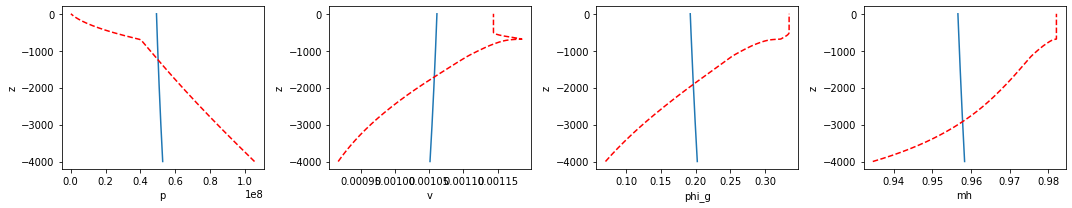

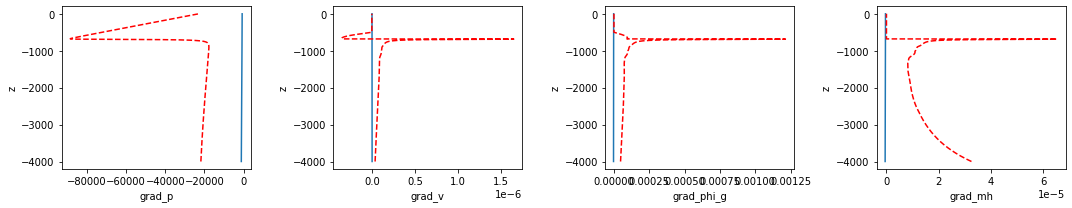

Training:   1%|          | 996/100000 [00:19<31:09, 52.94it/s] 

Step 1000 loss is 1.6135245459736325e-05
Step 1000 F is [0. 0. 0. 0.]


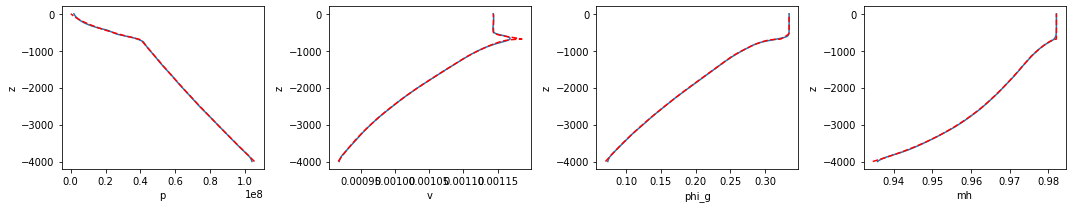

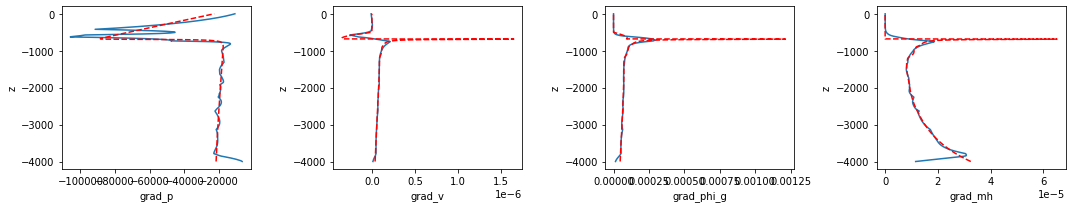

Training:   2%|▏         | 1998/100000 [00:39<30:21, 53.82it/s]  

Step 2000 loss is 0.00013207797019276768
Step 2000 F is [0. 0. 0. 0.]


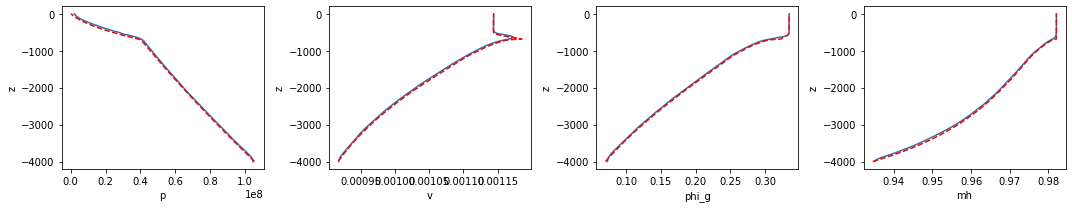

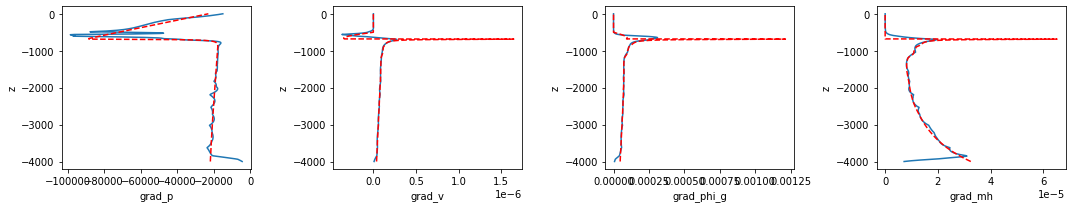

Training:   3%|▎         | 3000/100000 [00:58<30:09, 53.61it/s]  

Step 3000 loss is 1.2789913853339385e-05
Step 3000 F is [0. 0. 0. 0.]


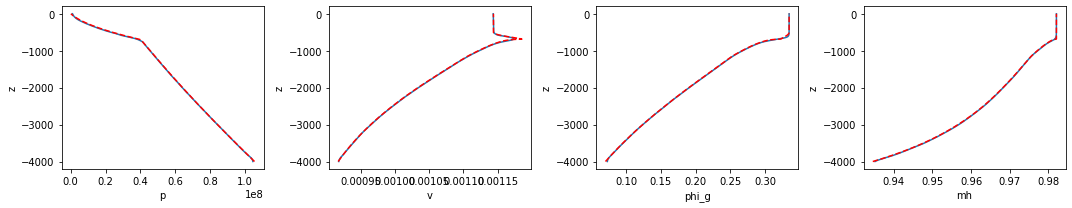

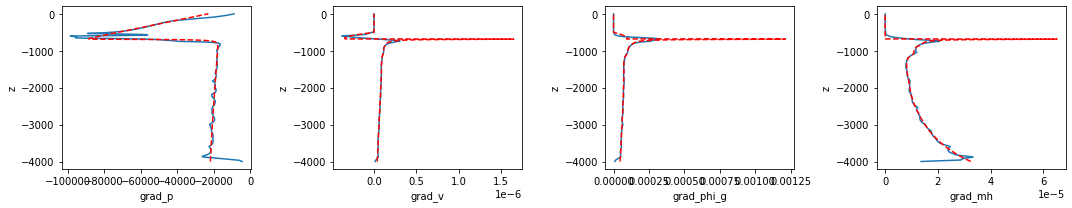

Training:   4%|▍         | 3995/100000 [01:18<29:54, 53.51it/s]  

Step 4000 loss is 9.61248078965582e-05
Step 4000 F is [0. 0. 0. 0.]


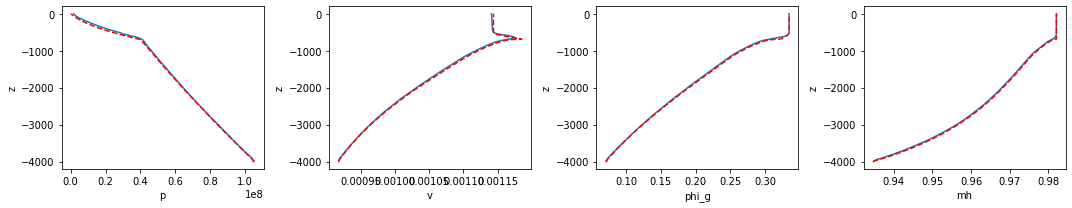

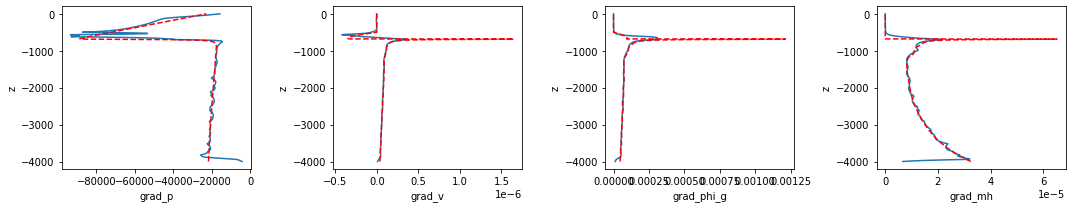

Training:   5%|▍         | 4985/100000 [01:37<29:33, 53.56it/s]  

Reducing learning rate


Training:   5%|▍         | 4997/100000 [01:37<29:38, 53.43it/s]

Step 5000 loss is 4.752470431412803e-06
Step 5000 F is [0. 0. 0. 0.]


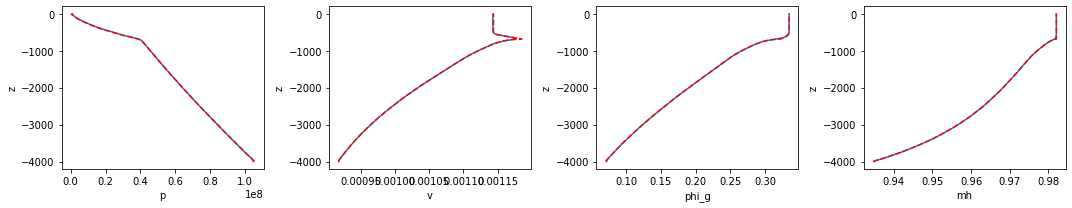

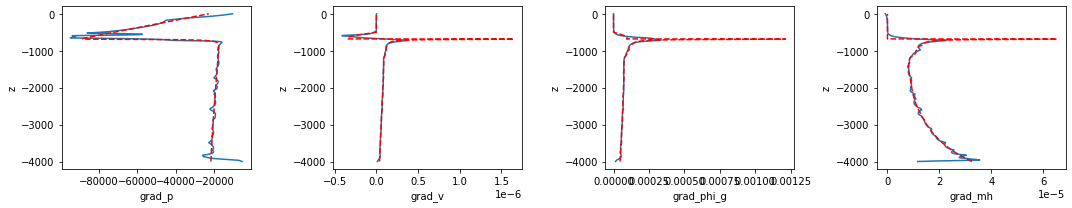

Training:   6%|▌         | 5999/100000 [01:56<29:21, 53.36it/s]  

Step 6000 loss is 2.446164671709994e-06
Step 6000 F is [0. 0. 0. 0.]


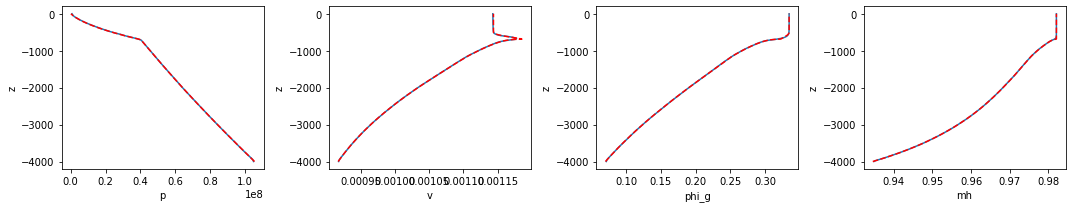

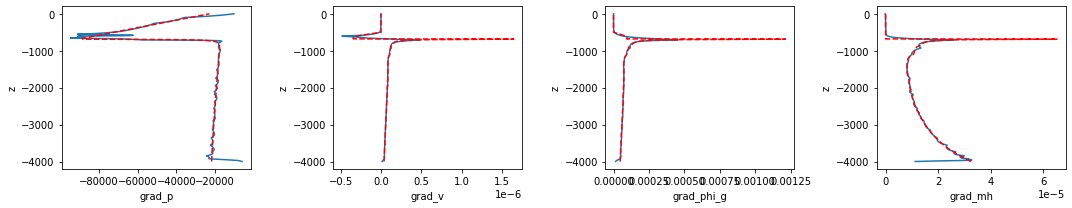

Training:   7%|▋         | 6995/100000 [02:16<28:53, 53.64it/s]  

Step 7000 loss is 7.935517714940943e-06
Step 7000 F is [0. 0. 0. 0.]


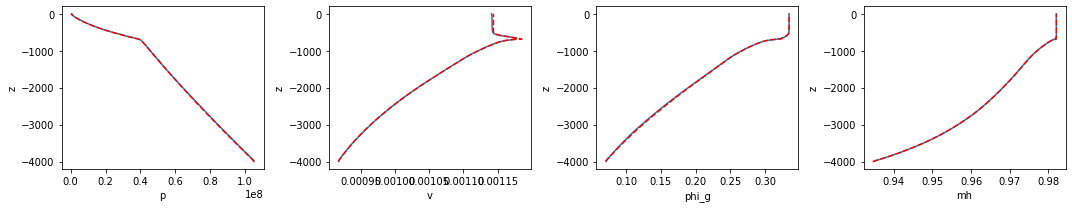

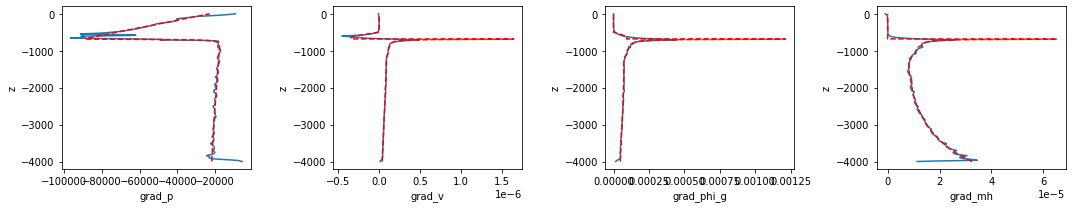

Training:   7%|▋         | 7091/100000 [02:18<29:06, 53.20it/s]  

Reducing learning rate


Training:   8%|▊         | 8000/100000 [02:36<29:00, 52.84it/s]

Step 8000 loss is 1.3478558003043872e-06
Step 8000 F is [0. 0. 0. 0.]


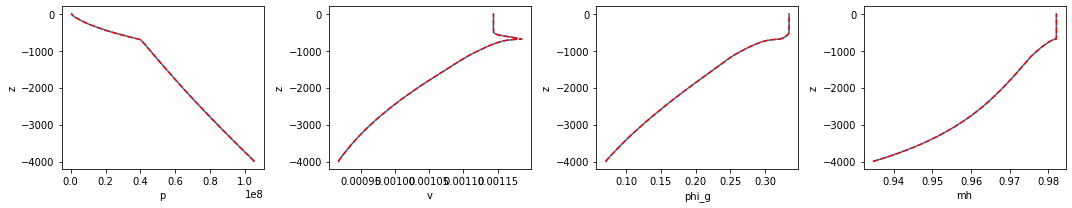

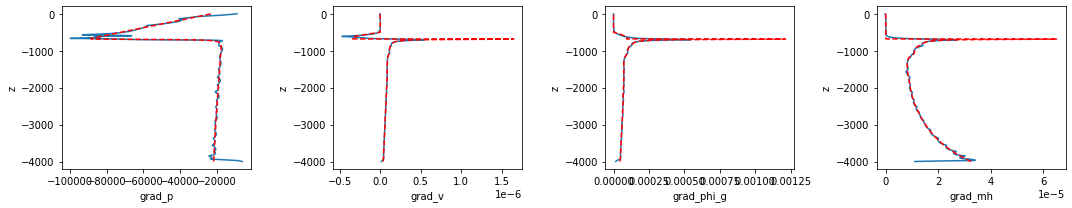

Training:   9%|▉         | 8998/100000 [02:55<28:03, 54.05it/s]  

Step 9000 loss is 3.983352598879719e-06
Step 9000 F is [0. 0. 0. 0.]


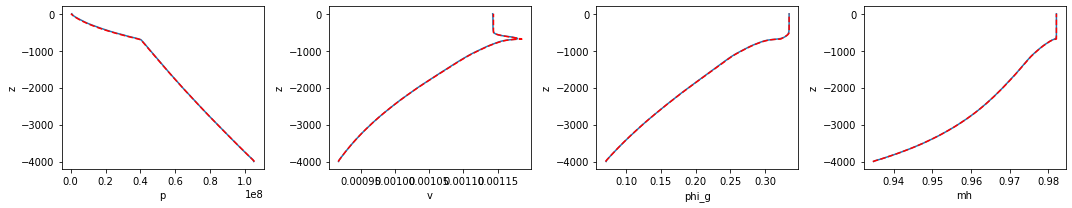

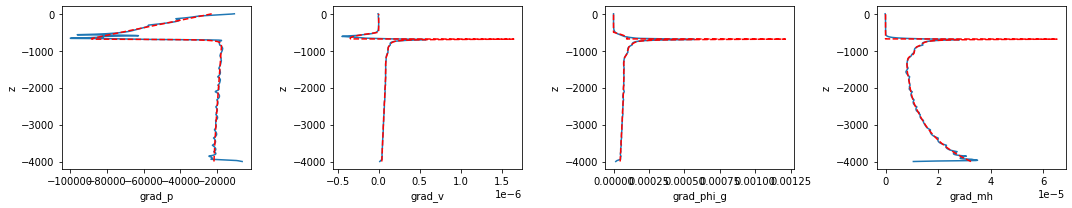

Training:  10%|█         | 10000/100000 [03:14<27:44, 54.07it/s] 

Step 10000 loss is 0.010677729733288288
Step 10000 F is [1.4554888e-09 1.3524653e-09 2.2481884e-10 3.4679340e-10]


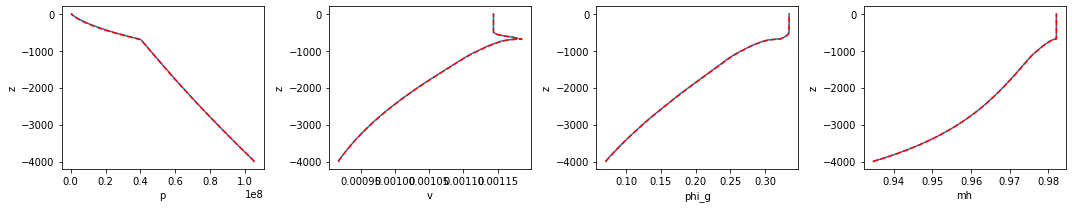

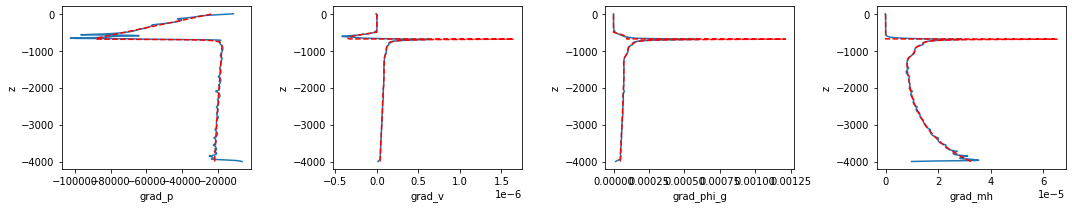

Training:  10%|█         | 10429/100000 [03:40<1:25:36, 17.44it/s]

Reducing learning rate


Training:  11%|█         | 10999/100000 [04:12<1:24:41, 17.51it/s]

Step 11000 loss is 0.010677729733288288
Step 11000 F is [1.4554888e-09 1.3524653e-09 2.2481884e-10 3.4679340e-10]


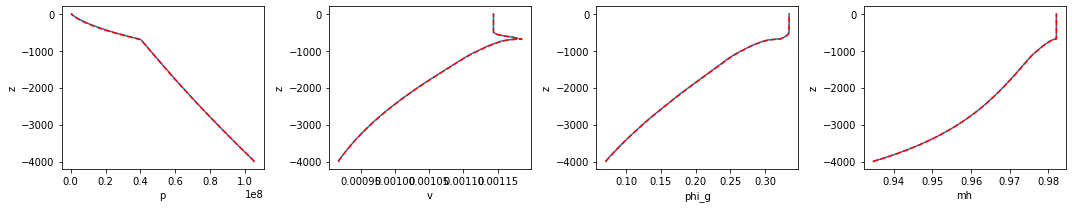

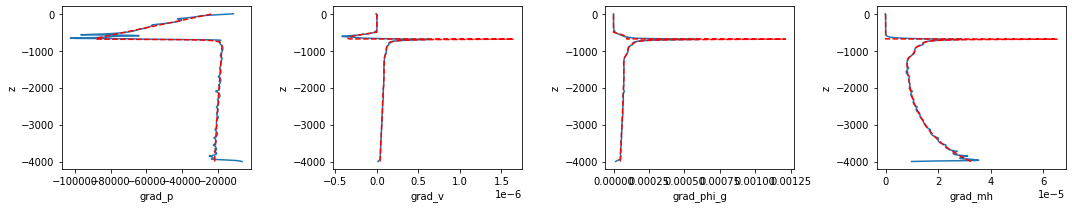

Training:  11%|█▏        | 11431/100000 [04:38<1:25:33, 17.25it/s]

Reducing learning rate


Training:  12%|█▏        | 11999/100000 [05:11<1:24:43, 17.31it/s]

Step 12000 loss is 0.010677729733288288
Step 12000 F is [1.4554888e-09 1.3524653e-09 2.2481884e-10 3.4679340e-10]


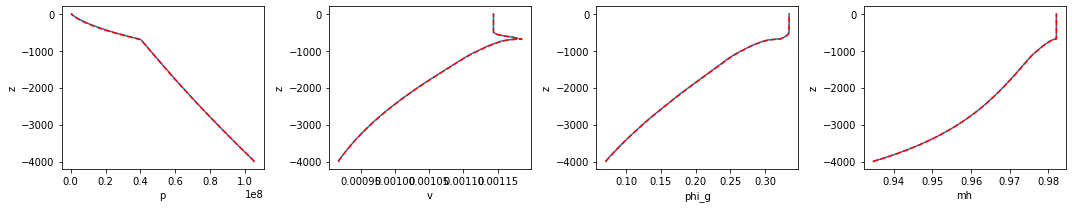

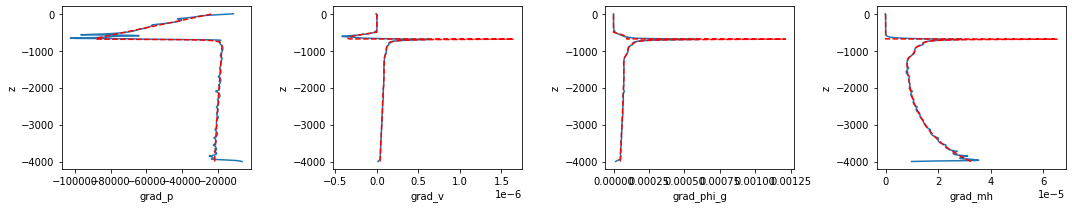

Training:  12%|█▏        | 12431/100000 [05:36<1:24:08, 17.34it/s]

Reducing learning rate


Training:  13%|█▎        | 12999/100000 [06:09<1:24:20, 17.19it/s]

Step 13000 loss is 0.010677729733288288
Step 13000 F is [1.4554888e-09 1.3524653e-09 2.2481884e-10 3.4679340e-10]


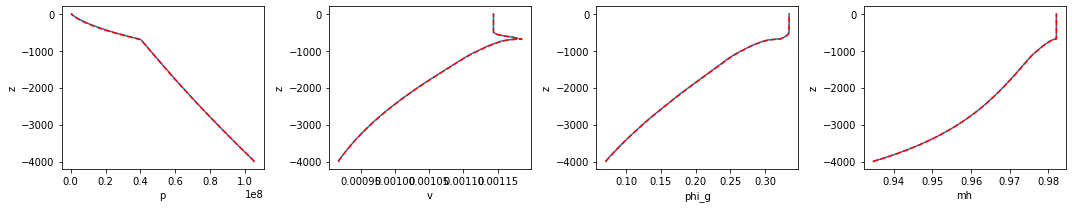

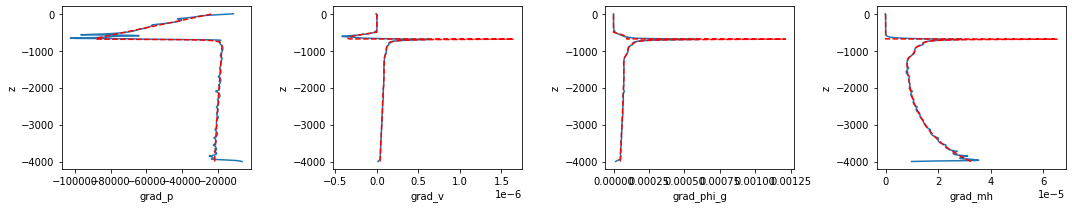

Training:  13%|█▎        | 13342/100000 [06:30<42:14, 34.20it/s]  


KeyboardInterrupt: 

In [20]:
N_EPOCHS=100000
N_DATA_EPOCHS=10000

conduit_nn = PDENeuralNet(N_INPUTS,N_OUTPUTS, activations= ACTIVATIONS) # should match the order of CONDUIT_VAR_NAMES) # First output is pressure, second is u

train(conduit_nn, dataset)

# How to add the physics

As a reminder, the neural network is set up to mimic the function $f(z,t) = [p, v, \phi_g, m_h](z,t)$, which is a map $\mathbb{R}^2 \to \mathbb{R}^4$.

In practice, we train the neural network with a "batch" of $(z,t)$ samples. This adds an extra dimension to the tensors being passed in and out of the model, where different elements of a batch are stacked along the first axis. Therefore, during training we expect inputs of size $(N,2)$ (2 because of z and t) and outputs of size $(N,4)$ (4 because of the conduit model outputs), where $N$ is the batch size.

## Steady-State Governing Equations

We can write the governing equations for the steady-state conduit model in the form (YQ is working on this)

$$F(z, [\nu, \partial_z \nu]) = 0$$

where $F$ is a matrix of size $(M,1)$ governing equations and $[\nu, \partial_z \nu]$ is a 8-element vector containing the primary conduit variables and their gradients with respect to $z$, e.g. a vector $[p, v, \phi_g, m_h, \partial_z p, \partial_z v, \partial_z \phi_g, \partial_z m_h]$. If we want to write this as a matrix-vector equation, we can express it as 

$$ F(z, [\nu, \partial_z \nu]) = J(z, \nu) \frac{\partial \nu}{\partial z} + Q(z, \nu, \partial_z p) = 0, $$

where $ J(z, \nu)$ is a matrix of size $(M,4)$ containing the coefficients for $\partial_z \nu$ in the $M$ governing equations. However, one issue is that in the  momentum balance equation, $\partial_z p$ appears in the sinh function for the frictional velocity and is therefore not linear in $\partial_z p$, thus  $Q_{mbe}$ does contain the $\partial_z p$ term. 

**Q for Ben**: can we just rewrite the equations in the form $F(z, \nu) = 0$, instead of $J(z, \nu) \frac{\partial \nu}{\partial z} + Q(\nu) = 0$? Since $Q(\nu)$ is so weird and contains $\partial_z p$. Seems like the loss only calculates $F$ anyway. Maybe it would help if you just write down what the loss calculation would be?

Also, how to implement boundary conditions?

**A for YQ**: yes! We can definitely do that. No tensorflow reason to do one or the other -- I just figured you would have written the equations in the $J$, etc. way in your matlab code. I've re-written the loss function to show how that's done.

The tensorflow code will produce conduit variables and their associated derivatives of size (N x 1) (where $N$ is the batch size). From these variables it is easy to assemble the vector $\nu$.

**What we still need:** a function that takes in these variables and gradients, and assembles the matrix $J$. 

Note that because of the batch dimension, $J$ will no longer be of size $(M,12)$, but should be of size $(N,M,12)$. We can then take this tensor and multiply it with $\nu$ to get the governing equations.




## Time-Dependent Governing Equations
The time-dependent governing equations can be rewritten as 

$$H(t, z, [\nu, \partial_z \nu, \partial_t \nu]) = 0, $$

where $H$ is a matrix of size $(M,1)$ governing equations and $[\nu, \partial_z \nu, \partial_t \nu]$ is now a 12-element vector containing the primary conduit variables and their gradients with respect to $z$, e.g. a vector $[p, v, \phi_g, m_h, \partial_z p, \partial_z v, \partial_z \phi_g, \partial_z m_h, \partial_t p, \partial_t v, \partial_t \phi_g, \partial_t m_h]$. We can actually reduce this by one because $ \partial_t v$ does not appear in the governing equations due to low Reynolds number. But wait. Will this result in velocities being constant over time? The assumption here is that $v$ depends on the phase fractions and other properties, not on the inertial term.

If we want to write this as a matrix-vector equation, we can express it as 

$$ H(t, z, [\nu, \partial_z \nu, \partial_t \nu]) =  M(t, z, \nu) \frac{\partial \nu}{\partial t} -  J(t, z, \nu) \frac{\partial \nu}{\partial z} - Q(t, z, \nu, \partial_z p) = 0, $$

### Some numpy manipulations to show how to do the math once we have $J$ and $\nu$

In [ ]:
J = np.arange(5*3*4).reshape(5,3,4)
nu = np.arange(5*4).reshape(5,4)
result = np.zeros((5,3))

In [ ]:
for i in range(5):
  result[i,:] = J[i,:,:].dot(nu[i,:])
print(result)

In [ ]:
# Faster (?) alternative
result2 = np.einsum('ijk,ik->ij',J,nu)
print(result2)

In [ ]:
result == result2

In [48]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  tape.watch(x1)
  x4 = 2*x1
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3, x4])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None
